### Part 2: Predicting mortality in ICUs
#### Part a:

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import roc_curve
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string, re

In [64]:
class Data:
    def __init__(self, data, target):
        self.data = data
        self.target = target
    def getCleanData():
        pass
    def getCleanTarget():
        pass
    def getClean(df: pd.DataFrame) -> pd.DataFrame:
        pass 
    
class Dataset:
    def __init__(self, test: Data, train: Data):
        self.test = test
        self.train = train

In [46]:
min_max_scaler = MinMaxScaler()
tdf = pd.DataFrame([[1,2,1,0,1],[5,4,0,1,2],[5,6,0,1,2]], columns=["A","B","C","D","E"])
#min_max_scaler.fit_transform(tdf.iloc[:,-2:-1].values.reshape(2,1))
tdf.iloc[:,0:] = min_max_scaler.fit_transform(tdf.iloc[:,0:].values.astype(float))
tdf
#tdf.iloc[:,-1].values.reshape(2,1)

,A,B,C,D,E
0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.5,0.0,1.0,1.0
2,1.0,1.0,0.0,1.0,1.0


In [56]:
dataset = pd.read_csv("~/csc2548_ml4h/adult_icu.gz", compression='gzip')

min_max_scaler = MinMaxScaler()
dataset.iloc[:,3:] = min_max_scaler.fit_transform(dataset.iloc[:,3:].values.astype(float))

trainset = dataset[dataset.train == 1]
trainset.reset_index(drop=True, inplace=True)
trainset.pop("train")
target = trainset.pop("mort_icu")
train = Data(trainset, target)

testset = dataset[dataset.train == 0]
testset.reset_index(drop=True, inplace=True)
testset.pop("train")
target = testset.pop("mort_icu")
test = Data(testset, target)

adult_icu = Dataset(train, test)

display(adult_icu.train.data.shape)
display(adult_icu.test.data.shape)
display(adult_icu.test.data.head())
display(adult_icu.test.data.drop(["subject_id", "hadm_id", "icustay_id"], axis=1).columns)

(18983, 60)

(8365, 60)

,subject_id,hadm_id,icustay_id,age,first_hosp_stay,first_icu_stay,adult_icu,eth_asian,eth_black,eth_hispanic,...,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,6,107064,228232,0.671233,1.0,1.0,0.0,0.0,0.0,0.0,...,0.059233,0.482353,0.135549,0.333333,0.919942,0.022843,0.046479,0.551020,0.225092,0.017497
1,9,150750,220597,0.342466,1.0,1.0,0.0,0.0,0.0,0.0,...,0.052265,0.152941,0.110625,0.126984,0.066230,0.015228,0.033099,0.571429,0.055351,0.012331
2,13,143045,263738,0.315068,1.0,1.0,0.0,0.0,0.0,0.0,...,0.045296,0.211765,0.092261,0.182540,0.229258,0.017766,0.040141,0.561224,0.044280,0.027495
3,41,101757,237024,0.547945,1.0,0.0,0.0,0.0,0.0,0.0,...,0.055749,0.194118,0.077394,0.238095,0.182481,0.026596,0.057131,0.500000,0.047970,0.018497
4,59,104130,224440,0.972603,1.0,1.0,0.0,0.0,0.0,0.0,...,0.038328,0.400000,0.069086,0.206349,0.405386,0.022843,0.052113,0.561224,0.217712,0.007999


Index(['age', 'first_hosp_stay', 'first_icu_stay', 'adult_icu', 'eth_asian',
       'eth_black', 'eth_hispanic', 'eth_other', 'eth_white',
       'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN',
       'admType_URGENT', 'heartrate_min', 'heartrate_max', 'heartrate_mean',
       'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max',
       'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean',
       'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min',
       'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean',
       'glucose_min', 'glucose_max', 'glucose_mean', 'aniongap', 'albumin',
       'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'magnesium', 'phosphate',
       'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc'],
      dtype='object')

In [57]:
logisticRegression = LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000)
logisticRegression.fit(train.data.drop(["subject_id", "hadm_id", "icustay_id"], axis=1), train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

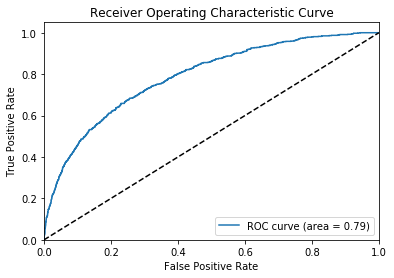

'AUC Score = 0.79'

In [58]:
prediction = logisticRegression.predict_proba(test.data.drop(["subject_id", "hadm_id", "icustay_id"], axis=1))
fpr, tpr, thresholds = roc_curve(test.target.values, prediction[:, 1])
auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
display("AUC Score = " + str(round(auc, 2)))

# Comment on model performance

In [60]:
accuracy = logisticRegression.score(test.data.drop(["subject_id", "hadm_id", "icustay_id"], axis=1), test.target) * 100
str(round(accuracy, 2)) + "%"

'90.84%'

In [62]:
feature_coefs = pd.Series(logisticRegression.coef_[0], index=train.data.drop(["subject_id", "hadm_id", "icustay_id"], axis=1).columns)
feature_coefs.sort_values(ascending=False, inplace=True)
display("Top 5 risk factors of mortality:")
display(feature_coefs.head(5).index.tolist())
display("Lowest 5 risk factors of mortality:")
display(feature_coefs.tail(5).index.tolist())

'Top 5 risk factors of mortality:'

['bilirubin', 'lactate', 'tempc_max', 'meanbp_mean', 'bun']

'Lowest 5 risk factors of mortality:'

['albumin', 'sysbp_min', 'platelet', 'tempc_mean', 'tempc_min']

# Explain what the above means

#### Part b:

In [13]:
dataset = pd.read_csv("~/csc2548_ml4h/adult_notes.gz", compression='gzip')
dataset = dataset[~pd.isnull(dataset.chartext)]

trainset = dataset[dataset.train == 1]
trainset.reset_index(drop=True, inplace=True)
trainset.pop("train")
target = trainset.pop("mort_icu")
notes_train = Dataset(trainset, target)

testset = dataset[dataset.train == 0]
testset.reset_index(drop=True, inplace=True)
testset.pop("train")
target = testset.pop("mort_icu")
notes_test = Dataset(testset, target)
display(notes_train.data.shape)
display(notes_test.data.shape)

(17956, 4)

(7923, 4)

In [14]:
def testfunc(x):
    return x + 2
testdf = pd.DataFrame([1,2,3,4,5], columns=["A"])
testdf.A = testfunc(testdf.A)
testdf.A
notes_train.data.chartext.head().values.shape

(5,)

In [15]:
stopwordList = stopwords.words("english")

def tokenize(s):
    return [j for j in [re.sub("\W+", '', i) for i in word_tokenize(s.lower())] 
            if j not in stopwordList and j != '']

vectorizer = TfidfVectorizer(tokenizer=tokenize)
vectorizer.fit(notes_train.data.chartext)
#testout = vectorizer.fit_transform(notes_train.data.head().chartext)
display(len(vectorizer.get_feature_names()))
#display(testout.toarray().shape)

#notes_train.data = notes_train.data.join(pd.DataFrame(testout.toarray(), columns=vectorizer.get_feature_names()))

#pd.DataFrame(testout.toarray(), columns=vectorizer.get_feature_names())
#notes_test.data.reset_index(drop=True, inplace=True)#print(vectorizer.get_feature_names()[0])

374355

In [1]:
vectorizer.get_feature_names()

NameError: name 'vectorizer' is not defined

In [35]:
notes_train_transformed = vectorizer.transform(notes_train.data.head().chartext)
#notes_train.data = notes_train.data.join(pd.DataFrame(transformed.toarray(), columns=vectorizer.get_feature_names()))
import scipy as sp
sp.sparse.hstack((notes_train.data.head().hadm_id[:,None],notes_train_transformed)).A
train.data.head()
#notes_train_transformed.A
#notes_test_transformed = vectorizer.transform(notes_test.data.chartext)
#notes_test.data = notes_test.data.join(pd.DataFrame(transformed.toarray(), columns=vectorizer.get_feature_names()))

# then transform and join notes_test
# then remove subject_id, hadm_id, icustay_id, chartext, and train logisticClassifier
# then test with notes_test (having removed similar) and get top 5 words/lowest 5 words, 
# ROC/AUC, plot, etc

,subject_id,hadm_id,icustay_id,age,first_hosp_stay,first_icu_stay,adult_icu,eth_asian,eth_black,eth_hispanic,...,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,3,145834,211552,76.0,1,1,1,0,0,0,...,2.4,4.8,282.0,5.4,30.7,1.3,13.5,136.0,53.0,12.7
1,12,112213,232669,72.0,1,1,1,0,0,0,...,1.7,6.6,156.0,4.9,55.2,1.7,15.9,138.0,28.0,8.4
2,17,194023,277042,47.0,1,1,1,0,0,0,...,1.4,2.0,138.0,3.9,31.8,1.5,14.9,139.0,11.0,10.5
3,21,109451,217847,87.0,1,1,1,0,0,0,...,2.0,5.9,261.0,5.0,150.0,4.0,23.5,140.0,94.0,23.5
4,21,111970,216859,87.0,0,1,1,0,0,0,...,1.5,4.4,275.0,3.8,31.7,1.7,18.1,137.0,49.0,30.5


In [164]:
#notes_test_transformed = vectorizer.transform(notes_test.data.chartext)
#notes_test_transformed

<7923x375795 sparse matrix of type '<class 'numpy.float64'>'
	with 5034726 stored elements in Compressed Sparse Row format>